# Input File

In [1]:
# === Config Cell (run first) ===
# Path to cleaned dataset
DATA_PATH = "/kaggle/input/data-preprocessing-assignment/emotions_clean.csv"

# Random seed for reproducibility
RAND = 42

# Label mapping
LABEL_MAP = {0:"Sadness",1:"Joy",2:"Love",3:"Anger",4:"Fear",5:"Surprise"}

## XGBoost (Extreme Gradient Boosting)

XGBoost is a high-performance implementation of the **Gradient Boosting** algorithm, designed for speed and accuracy.  
It builds an ensemble of **decision trees**, where each new tree corrects the errors made by the previous ones.  

- Works well with **tabular and text data** (after feature extraction such as TF-IDF or embeddings).  
- Uses advanced techniques like **regularization**, **shrinkage (learning rate)**, and **parallel processing** to improve efficiency and reduce overfitting.  
- Often considered one of the **state-of-the-art algorithms** in many machine learning competitions (e.g., Kaggle).  

**Advantages:**
- Very powerful and flexible, often achieving high accuracy.  
- Handles large datasets efficiently.  
- Built-in regularization helps prevent overfitting.  

**Limitations:**
- More complex and less interpretable than Logistic Regression or Naïve Bayes.  
- Requires careful tuning of hyperparameters for best performance.  
- Slower to train compared to simpler linear models.  

In [2]:
# === XGBoost (XGBClassifier): validate, plot, retrain on Train+Val, test, save ===
# Kaggle prep: ensure xgboost >= 1.6.0
import importlib, sys, subprocess

def ensure_xgb(min_version="1.6.0"):
    try:
        xgb = importlib.import_module("xgboost")
        from packaging.version import Version
        if Version(xgb.__version__) < Version(min_version):
            raise ImportError
        print(f"[OK] xgboost {xgb.__version__} >= {min_version}")
    except Exception:
        print(f"[SETUP] Installing xgboost>={min_version} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", f"xgboost>={min_version}"])
        importlib.invalidate_caches()
        print("[SETUP] xgboost installed.")

ensure_xgb("1.6.0")

[OK] xgboost 2.0.3 >= 1.6.0


Samples: 
  train: 237389 
  val  : 50869 
  test : 50870

Validation comparison (XGBoost config → Macro-F1 / Accuracy):
  d6_lr0.10_n300    macroF1=0.9202  acc=0.9345
  d6_lr0.05_n500    macroF1=0.9161  acc=0.9296
  d8_lr0.10_n300    macroF1=0.9279  acc=0.9424
  d8_lr0.05_n500    macroF1=0.9232  acc=0.9376

Best config on validation: d8_lr0.10_n300 (macroF1=0.9279)


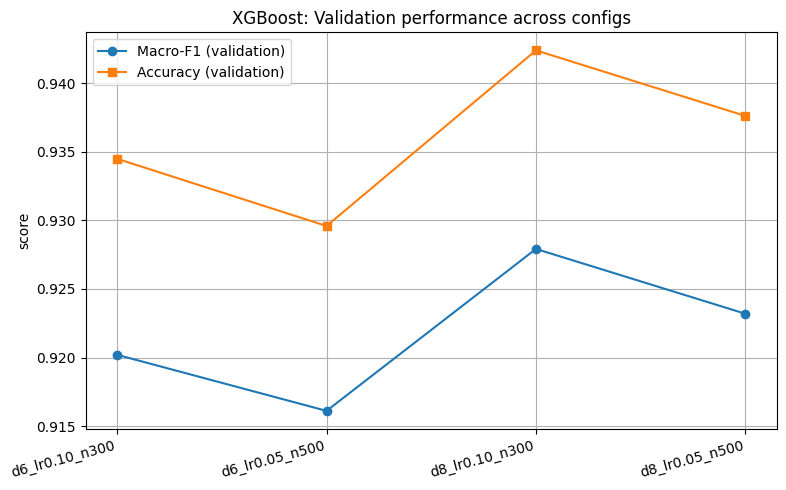


=== XGBoost — Final Test Report ===
              precision    recall  f1-score   support

           0     0.9790    0.9239    0.9507     15541
           1     0.9708    0.9414    0.9558     17887
           2     0.8432    0.9551    0.8957      3430
           3     0.9077    0.9656    0.9358      7153
           4     0.9273    0.9640    0.9453      5479
           5     0.8213    0.9928    0.8990      1380

    accuracy                         0.9442     50870
   macro avg     0.9082    0.9571    0.9304     50870
weighted avg     0.9471    0.9442    0.9447     50870



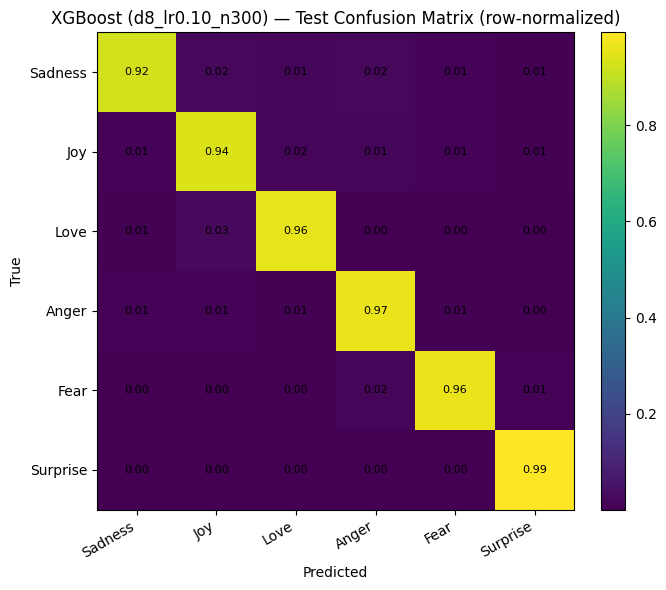

Saved: /kaggle/working/xgb_best_model.pkl


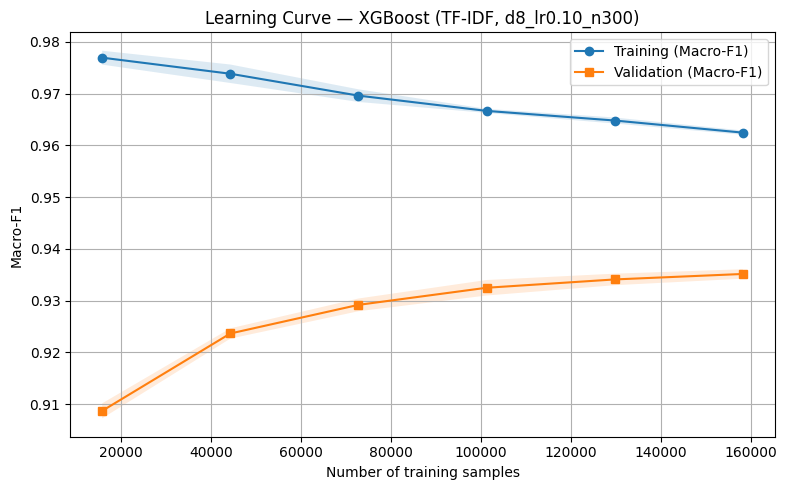

In [3]:
# === XGBoost on precomputed TF-IDF: tune, plot, retrain, test, save, learning curve ===
import numpy as np
import joblib
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import vstack

from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import learning_curve

from xgboost import XGBClassifier

# --- Load precomputed features/labels ---
X_train = sparse.load_npz("/kaggle/input/data-preprocessing-assignment/X_train_tfidf.npz")
X_val   = sparse.load_npz("/kaggle/input/data-preprocessing-assignment/X_val_tfidf.npz")
X_test  = sparse.load_npz("/kaggle/input/data-preprocessing-assignment/X_test_tfidf.npz")
y_train = np.load("/kaggle/input/data-preprocessing-assignment/y_train.npy")
y_val   = np.load("/kaggle/input/data-preprocessing-assignment/y_val.npy")
y_test  = np.load("/kaggle/input/data-preprocessing-assignment/y_test.npy")

print("Samples:",
      "\n  train:", len(y_train),
      "\n  val  :", len(y_val),
      "\n  test :", len(y_test))

# --- Class weights for imbalance (produce sample_weight for training) ---
classes = np.array(sorted(np.unique(y_train)))
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
cw_map = {c:w for c,w in zip(classes, class_weights)}
def make_sample_weight(y_vec):
    return np.vectorize(cw_map.get)(y_vec)

train_sw = make_sample_weight(y_train)

# --- Config grid (fast & strong) ---
XGB_GRID = [
    {"name": "d6_lr0.10_n300", "max_depth": 6, "learning_rate": 0.10, "n_estimators": 300},
    {"name": "d6_lr0.05_n500", "max_depth": 6, "learning_rate": 0.05, "n_estimators": 500},
    {"name": "d8_lr0.10_n300", "max_depth": 8, "learning_rate": 0.10, "n_estimators": 300},
    {"name": "d8_lr0.05_n500", "max_depth": 8, "learning_rate": 0.05, "n_estimators": 500},
]

def make_xgb(cfg):
    return XGBClassifier(
        # multiclass
        objective="multi:softprob",
        num_class=6,
        # core hypers
        max_depth=cfg["max_depth"],
        learning_rate=cfg["learning_rate"],
        n_estimators=cfg["n_estimators"],
        # regularization & speed
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        min_child_weight=1.0,
        tree_method="hist",
        n_jobs=-1,
        random_state=42,
        eval_metric="mlogloss",
        verbosity=0
    )

# --- Tune on validation ---
records = []   # (name, macroF1, acc, cfg)
best_cfg, best_f1 = None, -1.0

for cfg in XGB_GRID:
    clf = make_xgb(cfg)
    clf.fit(X_train, y_train, sample_weight=train_sw)
    yv = clf.predict(X_val)
    f1m = f1_score(y_val, yv, average="macro")
    acc = accuracy_score(y_val, yv)
    records.append((cfg["name"], f1m, acc, cfg))
    if f1m > best_f1:
        best_f1, best_cfg = f1m, cfg

print("\nValidation comparison (XGBoost config → Macro-F1 / Accuracy):")
for name, f1m, acc, _ in records:
    print(f"  {name:<16}  macroF1={f1m:.4f}  acc={acc:.4f}")
print(f"\nBest config on validation: {best_cfg['name']} (macroF1={best_f1:.4f})")

# --- Plot validation sweep ---
names = [r[0] for r in records]
f1s   = [r[1] for r in records]
accs  = [r[2] for r in records]
x = np.arange(len(names))

plt.figure(figsize=(8,5))
plt.plot(x, f1s, marker="o", label="Macro-F1 (validation)")
plt.plot(x, accs, marker="s", label="Accuracy (validation)")
plt.xticks(x, names, rotation=15, ha="right")
plt.ylabel("score")
plt.title("XGBoost: Validation performance across configs")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# --- Retrain on Train+Val with best config ---
X_trval = vstack([X_train, X_val])
y_trval = np.concatenate([y_train, y_val])
train_val_sw = make_sample_weight(y_trval)

final_xgb = make_xgb(best_cfg)
final_xgb.fit(X_trval, y_trval, sample_weight=train_val_sw)

# --- Final test evaluation ---
yt = final_xgb.predict(X_test)
print("\n=== XGBoost — Final Test Report ===")
print(classification_report(y_test, yt, digits=4))

# Confusion matrix (row-normalized)
LABEL_MAP = {0:"Sadness",1:"Joy",2:"Love",3:"Anger",4:"Fear",5:"Surprise"}
cm = confusion_matrix(y_test, yt, labels=[0,1,2,3,4,5])
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(7.5,6))
im = ax.imshow(cm_norm, interpolation='nearest')
ax.set_title(f"XGBoost ({best_cfg['name']}) — Test Confusion Matrix (row-normalized)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(6)); ax.set_yticks(range(6))
ax.set_xticklabels([LABEL_MAP[i] for i in range(6)], rotation=30, ha="right")
ax.set_yticklabels([LABEL_MAP[i] for i in range(6)])
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, f"{cm_norm[i,j]:.2f}", ha="center", va="center", fontsize=8)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# --- Save the trained classifier (model-only) ---
joblib.dump(final_xgb, "/kaggle/working/xgb_best_model.pkl")
print("Saved: /kaggle/working/xgb_best_model.pkl")

# =======================
# === Learning Curve  ===
# =======================
# Learning curve on precomputed TRAIN matrix (no leakage).
lc_clf = make_xgb(best_cfg)

train_sizes = np.linspace(0.1, 1.0, 6)  # 10%, 28%, ..., 100%
train_sizes_abs, train_scores, val_scores = learning_curve(
    estimator=lc_clf,
    X=X_train,      # only TRAIN split
    y=y_train,
    cv=3,
    scoring="f1_macro",
    train_sizes=train_sizes,
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes_abs, train_mean, marker="o", label="Training (Macro-F1)")
plt.fill_between(train_sizes_abs, train_mean-train_std, train_mean+train_std, alpha=0.15)
plt.plot(train_sizes_abs, val_mean, marker="s", label="Validation (Macro-F1)")
plt.fill_between(train_sizes_abs, val_mean-val_std, val_mean+val_std, alpha=0.15)
plt.xlabel("Number of training samples")
plt.ylabel("Macro-F1")
plt.title(f"Learning Curve — XGBoost (TF-IDF, {best_cfg['name']})")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()